In [1]:
Seurat_RObj_path="/data/home/hyunjin.kim2/SimpleTasks/data/tx_fil_dim20_res250.Robj"
outputDir="/data/home/hyunjin.kim2/SimpleTasks/results/PID4604/"

### load libraries
if(!require(Seurat, quietly = TRUE)) {
    install.packages("Seurat")
    require(Seurat, quietly = TRUE)
}
if(!require(devtools, quietly = TRUE)) {
    install.packages("devtools")
    require(devtools, quietly = TRUE)
}
if(!require(monocle3, quietly = TRUE)) {
    devtools::install_github('cole-trapnell-lab/monocle3')
    require(monocle3, quietly = TRUE)
}
if(!require(ggplot2, quietly = TRUE)) {
    install.packages("ggplot2")
    require(ggplot2, quietly = TRUE)
}
if(!require(igraph, quietly = TRUE)) {
    install.packages("igraph")
    require(igraph, quietly = TRUE)
}
if(!require(philentropy, quietly = TRUE)) {
    install.packages("philentropy")
    require(philentropy, quietly = TRUE)
}
if(!require(rgdal, quietly = TRUE)) {
    install.packages("rgdal", dependencies = TRUE)
    require(rgdal, quietly = TRUE)
}
if(!require(xlsx, quietly = TRUE)) {
    install.packages("xlsx")
    require(xlsx, quietly = TRUE)
}

### loads an RData file, and returns it
loadRData <- function(fileName){
    load(fileName)
    get(ls()[ls() != "fileName"])
}

### load R object
seurat_obj <- loadRData(Seurat_RObj_path)
gc()

### load the new annotation info
### id - cluster#, label - annotation info
new_anno <- read.table(file = "/data/home/hyunjin.kim2/SimpleTasks/data/cluster_annot.txt", header = TRUE, sep = "\t",
                       stringsAsFactors = FALSE, check.names = FALSE)
rownames(new_anno) <- new_anno$id

### annotate
seurat_obj$new_anno <- NA
for(clstr in unique(as.character(seurat_obj$seurat_clusters))) {
    seurat_obj$new_anno[which(seurat_obj$seurat_clusters == clstr)] <- new_anno[clstr,"label"]
}

### rownames in the meta.data should be in the same order as colnames in the counts
print(identical(rownames(seurat_obj@assays$RNA@counts), rownames(seurat_obj@assays$RNA@data)))
print(identical(rownames(seurat_obj@assays$RNA@counts), rownames(seurat_obj@assays$RNA@scale.data)))
print(identical(colnames(seurat_obj@assays$RNA@counts), colnames(seurat_obj@assays$RNA@data)))
print(identical(colnames(seurat_obj@assays$RNA@counts), colnames(seurat_obj@assays$RNA@scale.data)))
print(identical(rownames(seurat_obj@meta.data), colnames(seurat_obj@assays$RNA@counts)))

Attaching SeuratObject

Registered S3 method overwritten by 'cli':
  method     from         
  print.boxx spatstat.geom


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.



Attaching package: ‘matrixStats’


The following objects are masked from ‘package:Biobase’:

    anyMiss

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,6623234,353.8,12964310,692.4,9313268,497.4
Vcells,1294311811,9874.9,1828193115,13948.1,1294323352,9875.0


[1] TRUE
[1] FALSE
[1] TRUE
[1] TRUE
[1] TRUE


In [7]:
### rownames in the meta.data should be in the same order as colnames in the counts
print(identical(rownames(seurat_obj@assays$RNA@counts), rownames(seurat_obj@assays$RNA@data)))
print(identical(rownames(seurat_obj@assays$RNA@counts), rownames(seurat_obj@assays$RNA@scale.data)))
print(identical(colnames(seurat_obj@assays$RNA@counts), colnames(seurat_obj@assays$RNA@data)))
print(identical(colnames(seurat_obj@assays$RNA@counts), colnames(seurat_obj@assays$RNA@scale.data)))
print(identical(rownames(seurat_obj@meta.data), colnames(seurat_obj@assays$RNA@counts)))

[1] TRUE
[1] FALSE
[1] TRUE
[1] TRUE
[1] TRUE


In [9]:
print(nrow(seurat_obj@assays$RNA@counts))
print(nrow(seurat_obj@assays$RNA@scale.data))

[1] 25127
[1] 2000


In [11]:
### Construct a monocle cds
cds <- new_cell_data_set(as(seurat_obj@assays$RNA@counts, 'sparseMatrix'),
                       cell_metadata = seurat_obj@meta.data,
                       gene_metadata = data.frame(gene_short_name = row.names(seurat_obj@assays$RNA@counts),
                                                  row.names = row.names(seurat_obj@assays$RNA@counts),
                                                  stringsAsFactors = FALSE, check.names = FALSE))

### check the order of cds@colData and seurat_obj@meta.data are the same
identical(as.character(cds@colData$seurat_clusters), as.character(seurat_obj$seurat_clusters))
identical(as.character(cds@colData$sample.cel), as.character(seurat_obj$sample.cel))
identical(as.character(cds@colData$sample.trt), as.character(seurat_obj$sample.trt))

### pre-process the data
cds <- preprocess_cds(cds, num_dim = 50)

### overwrite the current CDS UMAP with original seurat UMAP
cds@int_colData@listData$reducedDims$UMAP <- seurat_obj@reductions$umap@cell.embeddings

### cluster the data
cds <- cluster_cells(cds)

### learn trajectory 
cds <- learn_graph(cds)

[1] TRUE

[1] TRUE

[1] TRUE

  |======================================================================| 100%
  |======================================================================| 100%


In [12]:
### remove "-" cluster and do the analysis again
seurat_obj <- subset(seurat_obj,
                     cells = rownames(seurat_obj@meta.data)[which(seurat_obj$new_anno != "-")])

### construct a monocle cds
cds2 <- new_cell_data_set(as(seurat_obj@assays$RNA@counts, 'sparseMatrix'),
                          cell_metadata = seurat_obj@meta.data,
                          gene_metadata = data.frame(gene_short_name = row.names(seurat_obj@assays$RNA@counts),
                                                     row.names = row.names(seurat_obj@assays$RNA@counts),
                                                     stringsAsFactors = FALSE, check.names = FALSE))

### overwrite the current CDS UMAP with original seurat UMAP
cds2@int_colData@listData$reducedDims$UMAP <- seurat_obj@reductions$umap@cell.embeddings
  
### pre-process the data
cds2 <- preprocess_cds(cds2, num_dim = 50)

### cluster the data
cds2 <- cluster_cells(cds2)

### learn trajectory 
cds2 <- learn_graph(cds2)

  |======================================================================| 100%
  |======================================================================| 100%


In [17]:
dim(cds@colData)
dim(cds2@colData)

[1] 115959     16

[1] 114572     16

In [18]:
saveRDS(cds, "./cds.rds")

In [19]:
saveRDS(cds2, "./cds2.rds")

In [21]:
p <- plot_cells(cds,
                  label_roots = FALSE,
                  color_cells_by = "new_anno",
                  label_groups_by_cluster = FALSE,
                  label_leaves = FALSE,
                  label_branch_points = FALSE,
                  group_label_size = 7)

Warning message:
“`select_()` was deprecated in dplyr 0.7.0.
Please use `select()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated.”


In [24]:
p <- plot_cells(cds,
                  label_roots = FALSE,
                  color_cells_by = "new_anno",
                  label_groups_by_cluster = FALSE,
                  label_leaves = FALSE,
                  label_branch_points = FALSE,
                  group_label_size = 7)
p2 <- plot_cells(cds2,
                 label_roots = FALSE,
                 color_cells_by = "new_anno",
                 label_groups_by_cluster = FALSE,
                 label_leaves = FALSE,
                 label_branch_points = FALSE,
                 group_label_size = 7)

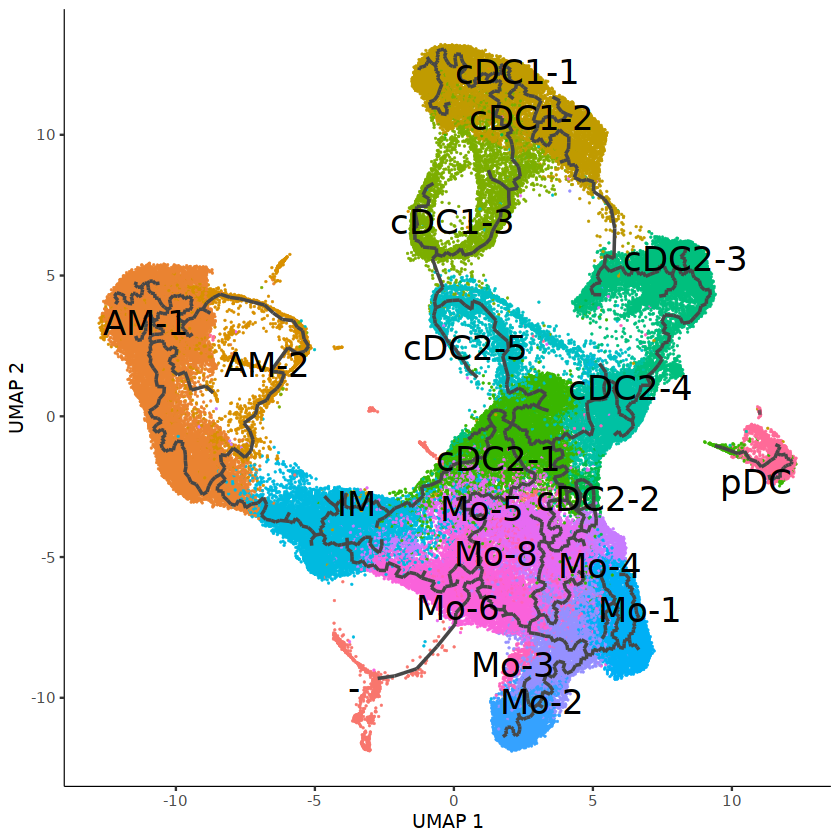

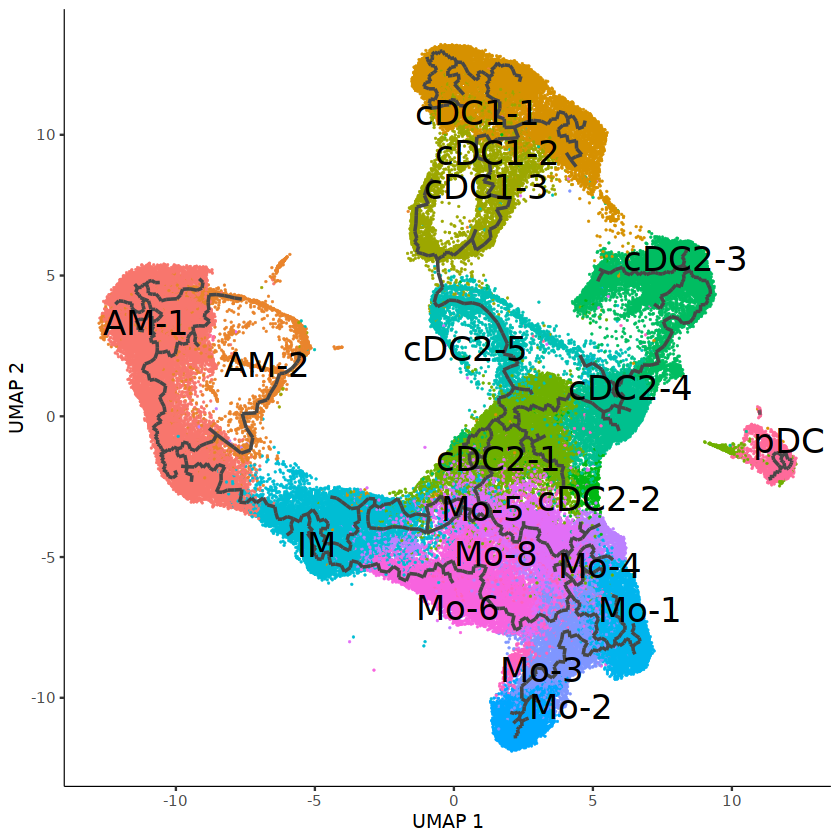

In [25]:
plot(p)
plot(p2)

In [26]:
nrow(cds@int_colData@listData$reducedDims$UMAP)
nrow(cds2@int_colData@listData$reducedDims$UMAP)

[1] 115959

[1] 114572

In [27]:
### cluster the data
cds3 <- cluster_cells(cds2,
                      reduction_method = "UMAP",
                      resolution = NULL,
                      random_seed = 1234)

### learn trajectory 
cds3 <- learn_graph(cds3)

  |======================================================================| 100%
  |======================================================================| 100%


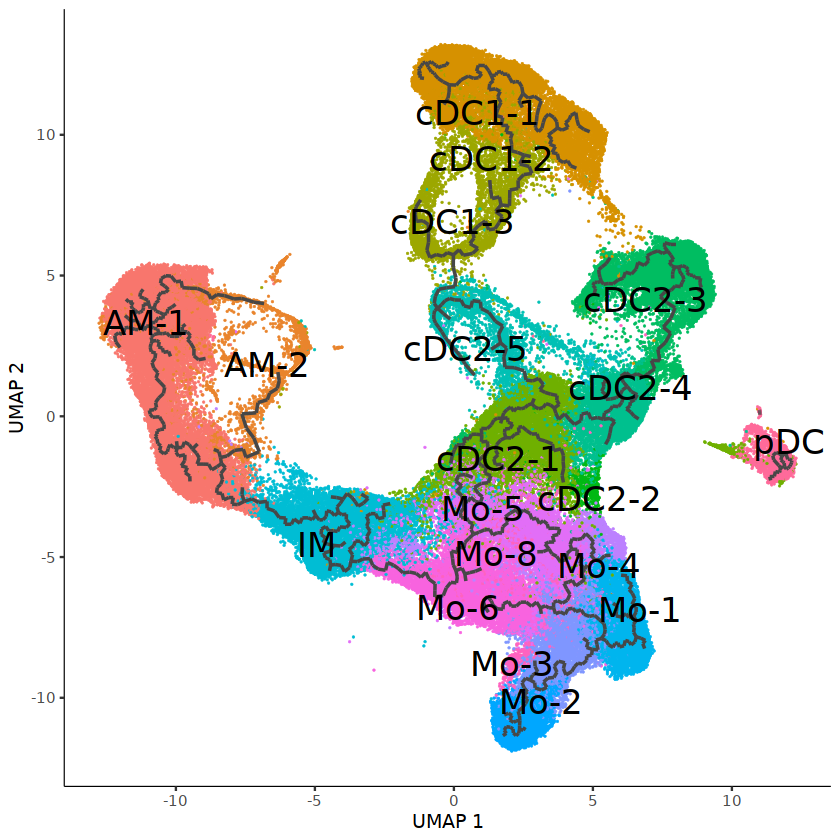

In [28]:
p3 <- plot_cells(cds3,
                 label_roots = FALSE,
                 color_cells_by = "new_anno",
                 label_groups_by_cluster = FALSE,
                 label_leaves = FALSE,
                 label_branch_points = FALSE,
                 group_label_size = 7)

plot(p3)

  |======================================================================| 100%
  |======================================================================| 100%


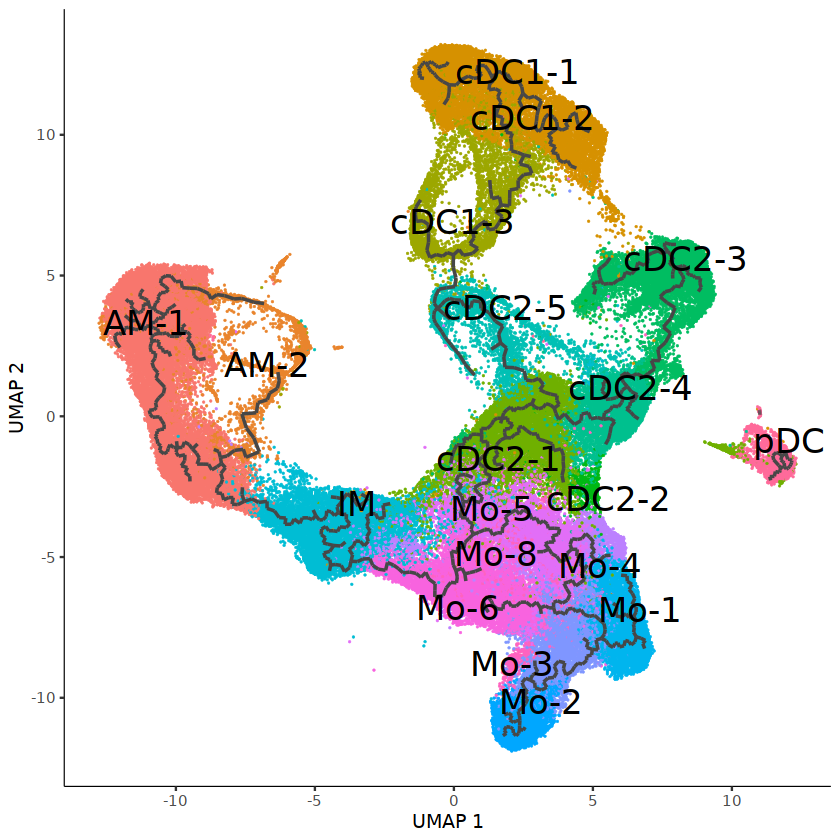

In [29]:
### cluster the data
cds4 <- cluster_cells(cds2,
                      reduction_method = "UMAP",
                      resolution = NULL,
                      random_seed = 4321)

### learn trajectory 
cds4 <- learn_graph(cds4)

p4 <- plot_cells(cds4,
                 label_roots = FALSE,
                 color_cells_by = "new_anno",
                 label_groups_by_cluster = FALSE,
                 label_leaves = FALSE,
                 label_branch_points = FALSE,
                 group_label_size = 7)

plot(p4)

  |======================================================================| 100%
  |======================================================================| 100%


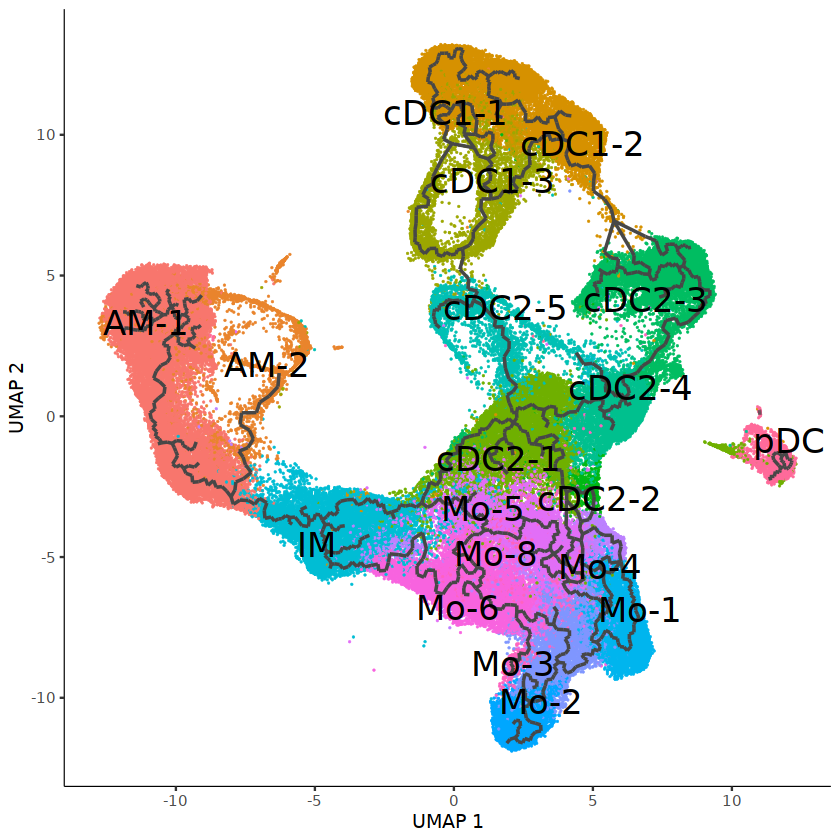

In [30]:
### cluster the data
cds5 <- cluster_cells(cds2,
                      reduction_method = "UMAP",
                      resolution = NULL,
                      random_seed = 7890)

### learn trajectory 
cds5 <- learn_graph(cds5)

p5 <- plot_cells(cds5,
                 label_roots = FALSE,
                 color_cells_by = "new_anno",
                 label_groups_by_cluster = FALSE,
                 label_leaves = FALSE,
                 label_branch_points = FALSE,
                 group_label_size = 7)

plot(p5)

In [ ]:
### cluster the data
cds6 <- cluster_cells(cds2,
                      reduction_method = "UMAP",
                      resolution = 0.1,
                      random_seed = 1234)

### learn trajectory 
cds6 <- learn_graph(cds6)

p6 <- plot_cells(cds6,
                 label_roots = FALSE,
                 color_cells_by = "new_anno",
                 label_groups_by_cluster = FALSE,
                 label_leaves = FALSE,
                 label_branch_points = FALSE,
                 group_label_size = 7)

plot(p6)